In [1]:
from typing import Any
import numpy as np
from numpy import linalg as la

import sys
EPS = sys.float_info.epsilon * 2

def top_k(x, q=0.05): # q - fraction of nonzero elements
    d = x.size
    k = int(np.ceil(d * q))
    
    mask = np.ones(d)
    positions = np.argpartition(np.abs(x), -k)[:-k]
    mask[positions] = 0
    code = mask * x # * d / q

    bits = (x.dtype.itemsize * 8) * k
    bits += min(
        k * np.log2(len(x)), # positions
        (d - k) * np.log2(len(x)), # not positions
        d, # mask
    )
    var = (la.norm(x - code) / la.norm(x))**2
    
    return code, bits, var

import torch
from eden import eden_builder

def eden(x, quant, n_bits):
    code, _ = quant.roundtrip(x)

    var = (la.norm(x - code) / la.norm(x))**2
    bits = n_bits * len(x) + 4
    return code, bits, var


from rot_sigma.rot_sigma import rot_sigma_builder
from scipy import integrate

def rot_sigma(x, quant):
    code, idk = quant.roundtrip(x)

    var = (la.norm(x - code) / la.norm(x))**2
    
    size = idk[1]
    nonzero = idk[-1]
    bits = nonzero * n_bits
    bits += min(
        nonzero * np.log2(size), # positions
        (size - nonzero) * np.log2(size), # not positions
        size, # mask
    )
    bits += 1 + 4

    return code, bits, var

In [2]:
SIZE = 3 * 2 ** 10
# SAMPLER = torch.distributions.laplace.Laplace(0,1)
SAMPLER = torch.distributions.normal.Normal(0,1)

def sample_vector():
    return SAMPLER.sample((SIZE,)) + torch.ones(SIZE) * 2


In [3]:
from tqdm import tqdm

NUM_REPEAT = 10

eden_variances_mean = []
eden_variances_std = []
eden_bits_mean = []
eden_bits_std = []
for n_bits in tqdm(np.concatenate((
    np.linspace(0.01, 0.4, num=40),
    np.linspace(0.4, 1.99, num=20),    
))):
    quant = eden_builder(bits=n_bits)

    current_variances = np.zeros(NUM_REPEAT)
    current_bits = np.zeros(NUM_REPEAT)

    for i in range(NUM_REPEAT):
        _, bit, var = eden(sample_vector(), quant, n_bits=n_bits)
        current_variances[i] = var
        current_bits[i] = bit / SIZE

    eden_variances_mean.append(np.mean(current_variances))
    eden_variances_std.append(np.std(current_variances) / np.sqrt(NUM_REPEAT - 1))
    eden_bits_mean.append(np.mean(current_bits))
    eden_bits_std.append(np.std(current_bits) / np.sqrt(NUM_REPEAT - 1))

100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


In [4]:
BITS = (1,2)

rot_variances_mean = {n_bits: [] for n_bits in BITS}
rot_variances_std = {n_bits: [] for n_bits in BITS}
rot_bits_mean = {n_bits: [] for n_bits in BITS}
rot_bits_std = {n_bits: [] for n_bits in BITS}


for n_bits in BITS:
    for sigmas in tqdm(np.concatenate((
        np.linspace(2, 5, num=30),
        np.linspace(0.1, 2, num=30),
    ))):
        quant = rot_sigma_builder(1, sigmas, n_bits, device='cpu')

        current_variances = np.zeros(NUM_REPEAT)
        current_bits = np.zeros(NUM_REPEAT)

        for i in range(NUM_REPEAT):
            _, bit, var = rot_sigma(sample_vector(), quant)
            current_variances[i] = var
            current_bits[i] = bit / SIZE
        
        rot_variances_mean[n_bits].append(np.mean(current_variances))
        rot_variances_std[n_bits].append(np.std(current_variances) / np.sqrt(NUM_REPEAT - 1))
        rot_bits_mean[n_bits].append(np.mean(current_bits))
        rot_bits_std[n_bits].append(np.std(current_bits) / np.sqrt(NUM_REPEAT - 1))

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


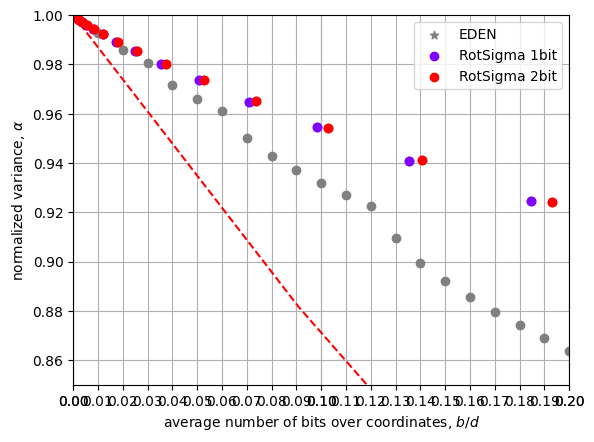

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.scatter(eden_bits_mean, eden_variances_mean, color="gray", label="EDEN", marker="*")
plt.errorbar(eden_bits_mean, eden_variances_mean, xerr=eden_bits_std, yerr=eden_variances_std, color="gray", capsize=3, fmt="o")

colors = cm.rainbow(np.linspace(0, 1, len(BITS)))
for n_bits, color in zip(BITS, colors):
    plt.scatter(rot_bits_mean[n_bits], rot_variances_mean[n_bits], color=color, label=f"RotSigma {n_bits}bit")
    plt.errorbar(rot_bits_mean[n_bits], rot_variances_mean[n_bits], xerr=rot_bits_std[n_bits], yerr=rot_variances_std[n_bits], color=color, capsize=3, fmt="o")

x = np.linspace(0, 9, num=100)
y = 4**(-x)
plt.plot(x, y, linestyle="--", color="red")

plt.xticks([i / 100 for i in range(21)] + [i / 10 for i in range(21)])
plt.grid()
plt.xlabel(r"average number of bits over coordinates, $b/d$")
plt.ylabel(r"normalized variance, $\alpha$")
plt.legend()
plt.xlim(0, 0.2)
plt.ylim(0.85, 1)
plt.show()

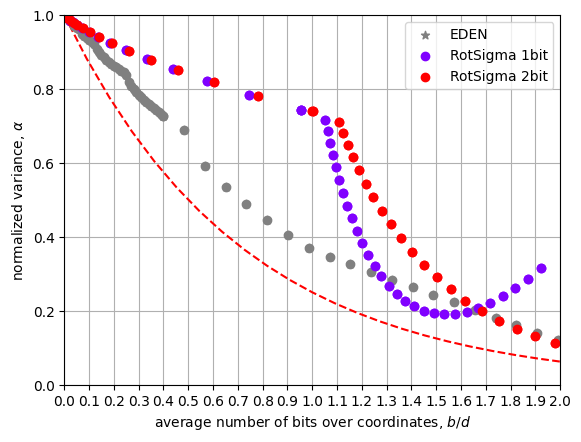

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.scatter(eden_bits_mean, eden_variances_mean, color="gray", label="EDEN", marker="*")
plt.errorbar(eden_bits_mean, eden_variances_mean, xerr=eden_bits_std, yerr=eden_variances_std, color="gray", capsize=3, fmt="o")

colors = cm.rainbow(np.linspace(0, 1, len(BITS)))
for n_bits, color in zip(BITS, colors):
    plt.scatter(rot_bits_mean[n_bits], rot_variances_mean[n_bits], color=color, label=f"RotSigma {n_bits}bit")
    plt.errorbar(rot_bits_mean[n_bits], rot_variances_mean[n_bits], xerr=rot_bits_std[n_bits], yerr=rot_variances_std[n_bits], color=color, capsize=3, fmt="o")

x = np.linspace(0, 9, num=100)
y = 4**(-x)
plt.plot(x, y, linestyle="--", color="red")

plt.xticks([i / 10 for i in range(21)])
plt.grid()
plt.xlabel(r"average number of bits over coordinates, $b/d$")
plt.ylabel(r"normalized variance, $\alpha$")
plt.legend()
plt.xlim(0, 2)
plt.ylim(0, 1)
plt.show()